In [1]:
# Added necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from collections import Counter
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
import seaborn as sns
import tensorflow as tf

In [2]:
# Loading the data files
non_demented_paths = ['./Data/Non Demented/' + filename for filename in os.listdir('./Data/Non Demented')]
very_mild_demented_paths = ['./Data/Very mild Dementia/' + filename for filename in os.listdir('./Data/Very mild Dementia')]
mild_demented_paths = ['./Data/Mild Dementia/' + filename for filename in os.listdir('./Data/Mild Dementia')]
moderate_demented_paths = ['./Data/Moderate Dementia/' + filename for filename in os.listdir('./Data/Moderate Dementia')]

# Combined paths and labels
image_paths = non_demented_paths + very_mild_demented_paths + mild_demented_paths + moderate_demented_paths
labels = [0] * len(non_demented_paths) + [1] * len(very_mild_demented_paths) + [2] * len(mild_demented_paths) + [3] * len(moderate_demented_paths)

In [3]:
# Display class distribution
print("Class Distribution:")
print("Non Demented:", len(non_demented_paths))
print("Very Mild Demented:", len(very_mild_demented_paths))
print("Mild Demented:", len(mild_demented_paths))
print("Moderate Demented:", len(moderate_demented_paths))

Class Distribution:
Non Demented: 67222
Very Mild Demented: 13725
Mild Demented: 5002
Moderate Demented: 488


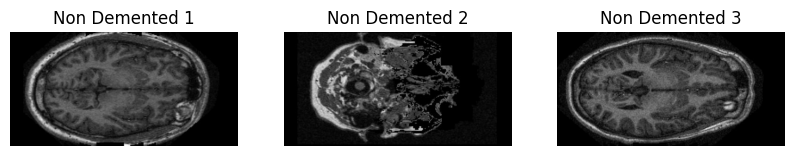

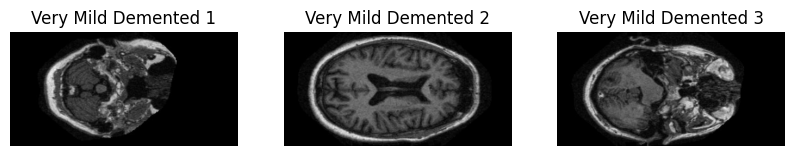

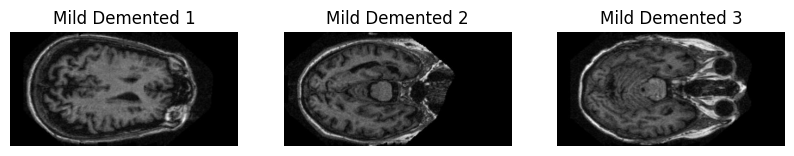

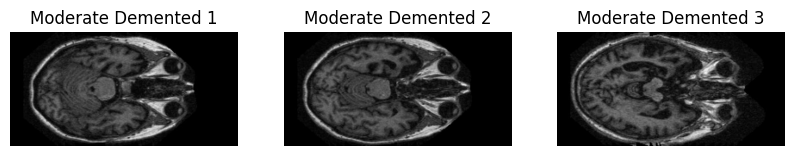

In [4]:
# Visualize Sample Images
def display_sample_images(paths, title):
    plt.figure(figsize=(10, 5))
    for i, path in enumerate(random.sample(paths, 3)):
        img = Image.open(path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()

display_sample_images(non_demented_paths, "Non Demented")
display_sample_images(very_mild_demented_paths, "Very Mild Demented")
display_sample_images(mild_demented_paths, "Mild Demented")
display_sample_images(moderate_demented_paths, "Moderate Demented")

Original class distribution: Counter({0: 67222, 1: 13725, 2: 5002, 3: 488})


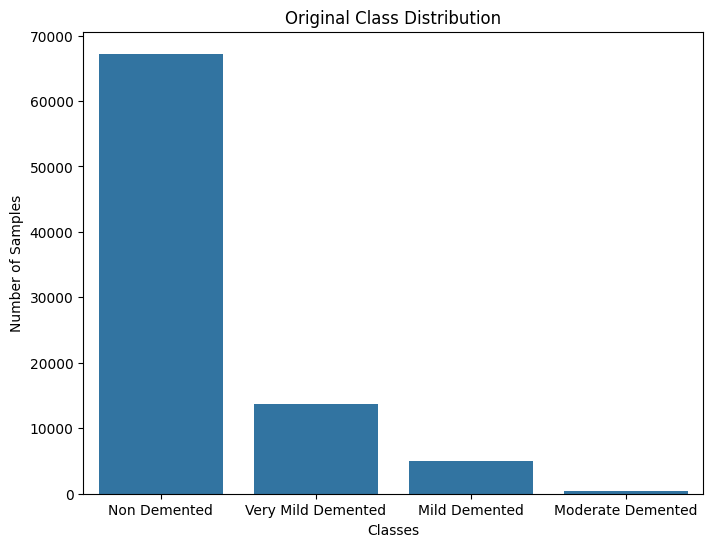

In [5]:
# Barplot for class distribution
class_names = ["Non Demented", "Very Mild Demented", "Mild Demented", "Moderate Demented"]
class_counts = Counter(labels)
print("Original class distribution:", class_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=[class_counts[i] for i in range(4)])
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Original Class Distribution")
plt.show()

In [6]:
# Splitting the data into train and test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

In [7]:
# Feature Extraction
def extract_features(image_paths, batch_size=32):
    model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    features = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = [preprocess_input(img_to_array(load_img(p, target_size=(128, 128)))) for p in batch_paths]
        batch_images = np.array(batch_images)
        batch_features = model.predict(batch_images, verbose=0)
        batch_features = batch_features.reshape(batch_features.shape[0], -1)
        features.extend(batch_features)
    return np.array(features)

# Extract features
train_features = extract_features(train_paths)
test_features = extract_features(test_paths)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [8]:
# SMOTE for Balancing the Dataset
encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(train_labels)

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(train_features, train_labels_encoded)
y_resampled = to_categorical(y_resampled)

print("Resampled shape:", x_resampled.shape)
print("Resampled class distribution:", Counter(np.argmax(y_resampled, axis=1)))

Resampled shape: (188220, 8192)
Resampled class distribution: Counter({0: 47055, 1: 47055, 3: 47055, 2: 47055})


In [9]:
# Defined CNN Model
from tensorflow.keras.regularizers import l2

def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(x_resampled.shape[1],), kernel_regularizer=l2(0.001)),
        Dropout(0.6),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.6),
        Dense(y_resampled.shape[1], activation='softmax')
     ])


    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(x_resampled.shape[1], y_resampled.shape[1])
model.summary()

/Users/yaswanthpati/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,130,820 (8.13 MB)

 Trainable params: 2,130,820 (8.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train Model on Re-sampled Data

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'best_model.keras',               
    monitor='val_loss',             
    mode='min',                     
    save_best_only=True,     
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(x_resampled, y_resampled, epochs=35, batch_size=32, validation_split=0.2, callbacks=[early_stopping, checkpoint])


Epoch 1/35
4705/4706 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4446 - loss: 2.4997
Epoch 1: val_loss improved from inf to 1.46645, saving model to best_model.keras
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 52s 11ms/step - accuracy: 0.4447 - loss: 2.4993 - val_accuracy: 0.4753 - val_loss: 1.4664
Epoch 2/35
4701/4706 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7270 - loss: 0.8538
Epoch 2: val_loss improved from 1.46645 to 1.11527, saving model to best_model.keras
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - accuracy: 0.7270 - loss: 0.8537 - val_accuracy: 0.4735 - val_loss: 1.1153
Epoch 3/35
4700/4706 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7866 - loss: 0.5485
Epoch 3: val_loss improved from 1.11527 to 0.78754, saving model to best_model.keras
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.7866 - loss: 0.5484 - val_accuracy: 0.4801 - val_loss: 0.7875
Epoch 4/35
4704/4706 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8365 - loss: 0.4012
Epoch 4: val_loss improved from 0

In [11]:
# Evaluation on Test Set
test_labels_encoded = to_categorical(encoder.transform(test_labels))
test_loss, test_accuracy = model.evaluate(test_features, test_labels_encoded)
print(f"Test Accuracy: {test_accuracy:.4f}")

811/811 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.9482 - loss: 0.1537
Test Accuracy: 0.9491


In [12]:
# Prediction and Evaluation
y_pred = model.predict(test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels_encoded, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step
                    precision    recall  f1-score   support

      Non Demented       1.00      0.94      0.97     20167
Very Mild Demented       0.78      0.99      0.87      4118
     Mild Demented       0.94      1.00      0.97      1501
 Moderate Demented       0.99      1.00      1.00       146

          accuracy                           0.95     25932
         macro avg       0.93      0.98      0.95     25932
      weighted avg       0.96      0.95      0.95     25932



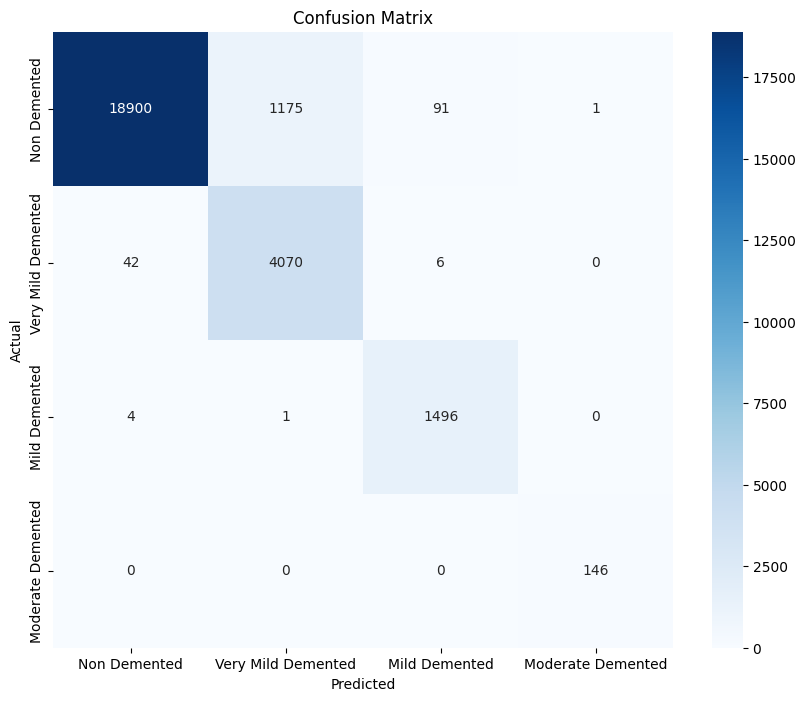

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# Cross-Validation with SMOTE
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_resampled_int = np.argmax(y_resampled, axis=1)
accuracy_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(x_resampled, y_resampled_int)):
    x_train_fold, x_val_fold = x_resampled[train_idx], x_resampled[val_idx]
    y_train_fold, y_val_fold = y_resampled[train_idx], y_resampled[val_idx]
    fold_model = create_model(x_train_fold.shape[1], y_resampled.shape[1])
    fold_model.fit(x_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(x_val_fold, y_val_fold), verbose=1)
    y_val_pred = np.argmax(fold_model.predict(x_val_fold), axis=1)
    y_val_true = np.argmax(y_val_fold, axis=1)
    accuracy = np.mean(y_val_pred == y_val_true)
    accuracy_scores.append(accuracy)
    print(f"\nFold {fold + 1} - Accuracy: {accuracy:.4f}")

print("\nAverage Cross-Validation Accuracy:", np.mean(accuracy_scores))

/Users/yaswanthpati/.pyenv/versions/3.10.16/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.4767 - loss: 2.6051 - val_accuracy: 0.8774 - val_loss: 0.6381
Epoch 2/10
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 99s 21ms/step - accuracy: 0.7681 - loss: 0.7851 - val_accuracy: 0.9272 - val_loss: 0.3135
Epoch 3/10
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.8323 - loss: 0.4821 - val_accuracy: 0.9540 - val_loss: 0.1722
Epoch 4/10
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.8760 - loss: 0.3416 - val_accuracy: 0.9632 - val_loss: 0.1473
Epoch 5/10
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.8994 - loss: 0.2861 - val_accuracy: 0.9703 - val_loss: 0.1181
Epoch 6/10
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9192 - loss: 0.2430 - val_accuracy: 0.9743 - val_loss: 0.1126
Epoch 7/10
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9253 - loss: 0.2277 - val_accuracy: 0.9679 - val_loss: 0.1203
Epoch 8/10
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.9323 - loss: 

In [18]:
# Convert and Save model to .h5 format (for Streamlit)
from tensorflow.keras.models import load_model

# Load .keras model if saved like this
model = load_model("best_model.keras")

# Save as .h5
model.save("model/model.h5")

print("Model successfully saved as model.h5")

Model successfully saved as model.h5
